##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 4202496/68606236 [>.............................] - ETA: 4s

15802368/68606236 [=====>........................] - ETA: 1s

28958720/68606236 [===========>..................] - ETA: 0s

41951232/68606236 [=================>............] - ETA: 1s

55574528/68606236 [=======================>......] - ETA: 0s

68608000/68606236 [==============================] - 2s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

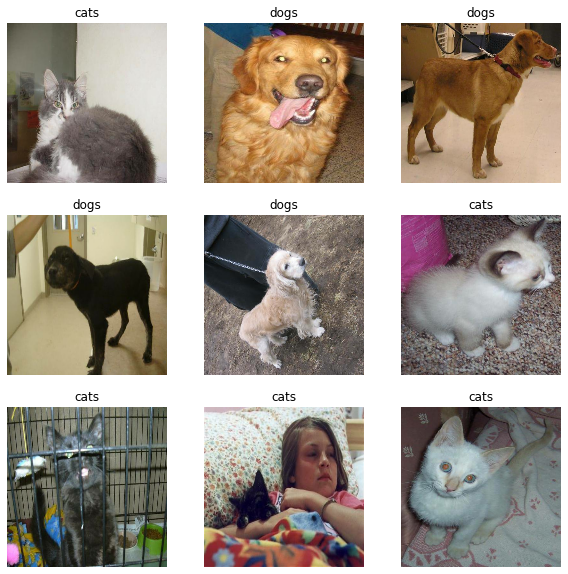

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

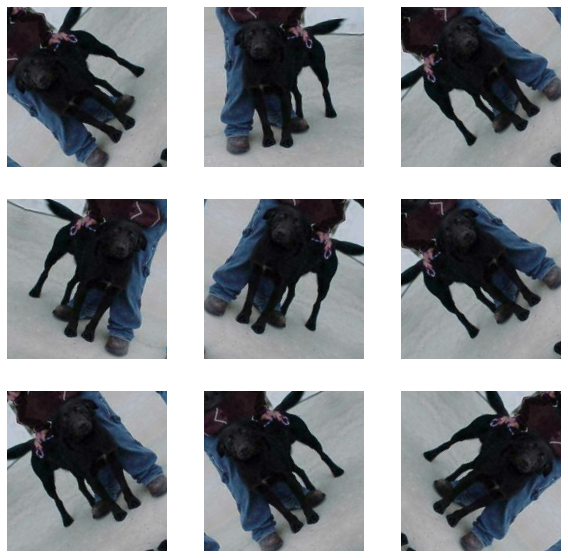

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

6676480/9406464 [====================>.........] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 32s - loss: 1.1589 - accuracy: 0.4375

 5/26 [====>.........................] - ETA: 0s - loss: 1.0782 - accuracy: 0.5063 

10/26 [==========>...................] - ETA: 0s - loss: 1.0190 - accuracy: 0.5375

15/26 [================>.............] - ETA: 0s - loss: 1.0340 - accuracy: 0.5375

20/26 [======================>.......] - ETA: 0s - loss: 1.0537 - accuracy: 0.5234

25/26 [===========================>..] - ETA: 0s - loss: 1.0574 - accuracy: 0.5213

26/26 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.5223

26/26 [==============================] - 2s 16ms/step - loss: 1.0528 - accuracy: 0.5223


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.05
initial accuracy: 0.52


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:23 - loss: 1.3585 - accuracy: 0.4375

 5/63 [=>............................] - ETA: 0s - loss: 1.2044 - accuracy: 0.4563  

 9/63 [===>..........................] - ETA: 0s - loss: 1.0674 - accuracy: 0.5347

13/63 [=====>........................] - ETA: 0s - loss: 1.0510 - accuracy: 0.5216

17/63 [=======>......................] - ETA: 0s - loss: 1.0407 - accuracy: 0.5184

21/63 [=========>....................] - ETA: 0s - loss: 1.0163 - accuracy: 0.5208

25/63 [==========>...................] - ETA: 0s - loss: 0.9727 - accuracy: 0.5375

29/63 [============>.................] - ETA: 0s - loss: 0.9448 - accuracy: 0.5463

33/63 [==============>...............] - ETA: 0s - loss: 0.9217 - accuracy: 0.5616

37/63 [================>.............] - ETA: 0s - loss: 0.8958 - accuracy: 0.5709

41/63 [==================>...........] - ETA: 0s - loss: 0.8853 - accuracy: 0.5694

45/63 [====================>.........] - ETA: 0s - loss: 0.8678 - accuracy: 0.5785

49/63 [======================>.......] - ETA: 0s - loss: 0.8491 - accuracy: 0.5842

53/63 [========================>.....] - ETA: 0s - loss: 0.8339 - accuracy: 0.5920

58/63 [==========================>...] - ETA: 0s - loss: 0.8159 - accuracy: 0.5959

63/63 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.6015

63/63 [==============================] - 4s 22ms/step - loss: 0.8021 - accuracy: 0.6015 - val_loss: 0.5626 - val_accuracy: 0.7166


Epoch 2/10
 1/63 [..............................] - ETA: 5s - loss: 0.6448 - accuracy: 0.6562

 5/63 [=>............................] - ETA: 0s - loss: 0.5969 - accuracy: 0.6500

 9/63 [===>..........................] - ETA: 0s - loss: 0.5920 - accuracy: 0.6875

13/63 [=====>........................] - ETA: 0s - loss: 0.5918 - accuracy: 0.6803

17/63 [=======>......................] - ETA: 0s - loss: 0.5796 - accuracy: 0.6838

21/63 [=========>....................] - ETA: 0s - loss: 0.5594 - accuracy: 0.6949

25/63 [==========>...................] - ETA: 0s - loss: 0.5610 - accuracy: 0.6938

29/63 [============>.................] - ETA: 0s - loss: 0.5597 - accuracy: 0.6983

33/63 [==============>...............] - ETA: 0s - loss: 0.5530 - accuracy: 0.7055

37/63 [================>.............] - ETA: 0s - loss: 0.5493 - accuracy: 0.7078

41/63 [==================>...........] - ETA: 0s - loss: 0.5411 - accuracy: 0.7104

45/63 [====================>.........] - ETA: 0s - loss: 0.5439 - accuracy: 0.7069

49/63 [======================>.......] - ETA: 0s - loss: 0.5425 - accuracy: 0.7054

53/63 [========================>.....] - ETA: 0s - loss: 0.5366 - accuracy: 0.7075

57/63 [==========================>...] - ETA: 0s - loss: 0.5294 - accuracy: 0.7138

62/63 [============================>.] - ETA: 0s - loss: 0.5251 - accuracy: 0.7177

63/63 [==============================] - 1s 20ms/step - loss: 0.5231 - accuracy: 0.7185 - val_loss: 0.4190 - val_accuracy: 0.8243


Epoch 3/10
 1/63 [..............................] - ETA: 5s - loss: 0.6067 - accuracy: 0.7812

 5/63 [=>............................] - ETA: 0s - loss: 0.5289 - accuracy: 0.7688

 9/63 [===>..........................] - ETA: 0s - loss: 0.5154 - accuracy: 0.7465

13/63 [=====>........................] - ETA: 0s - loss: 0.4873 - accuracy: 0.7596

17/63 [=======>......................] - ETA: 0s - loss: 0.4741 - accuracy: 0.7702

21/63 [=========>....................] - ETA: 0s - loss: 0.4627 - accuracy: 0.7812

25/63 [==========>...................] - ETA: 0s - loss: 0.4585 - accuracy: 0.7775

29/63 [============>.................] - ETA: 0s - loss: 0.4592 - accuracy: 0.7791

33/63 [==============>...............] - ETA: 0s - loss: 0.4519 - accuracy: 0.7812

37/63 [================>.............] - ETA: 0s - loss: 0.4513 - accuracy: 0.7804

41/63 [==================>...........] - ETA: 0s - loss: 0.4469 - accuracy: 0.7820

45/63 [====================>.........] - ETA: 0s - loss: 0.4452 - accuracy: 0.7812

49/63 [======================>.......] - ETA: 0s - loss: 0.4430 - accuracy: 0.7806

53/63 [========================>.....] - ETA: 0s - loss: 0.4396 - accuracy: 0.7854

58/63 [==========================>...] - ETA: 0s - loss: 0.4395 - accuracy: 0.7839

63/63 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.7880

63/63 [==============================] - 1s 20ms/step - loss: 0.4331 - accuracy: 0.7880 - val_loss: 0.3245 - val_accuracy: 0.8738


Epoch 4/10
 1/63 [..............................] - ETA: 5s - loss: 0.3931 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 0s - loss: 0.3916 - accuracy: 0.8375

 9/63 [===>..........................] - ETA: 0s - loss: 0.3821 - accuracy: 0.8403

13/63 [=====>........................] - ETA: 0s - loss: 0.3731 - accuracy: 0.8462

17/63 [=======>......................] - ETA: 0s - loss: 0.3788 - accuracy: 0.8346

21/63 [=========>....................] - ETA: 0s - loss: 0.3872 - accuracy: 0.8214

25/63 [==========>...................] - ETA: 0s - loss: 0.3849 - accuracy: 0.8300

29/63 [============>.................] - ETA: 0s - loss: 0.3798 - accuracy: 0.8254

33/63 [==============>...............] - ETA: 0s - loss: 0.3856 - accuracy: 0.8201

37/63 [================>.............] - ETA: 0s - loss: 0.3858 - accuracy: 0.8235

41/63 [==================>...........] - ETA: 0s - loss: 0.3845 - accuracy: 0.8277

45/63 [====================>.........] - ETA: 0s - loss: 0.3779 - accuracy: 0.8319

49/63 [======================>.......] - ETA: 0s - loss: 0.3754 - accuracy: 0.8291

53/63 [========================>.....] - ETA: 0s - loss: 0.3736 - accuracy: 0.8296

58/63 [==========================>...] - ETA: 0s - loss: 0.3678 - accuracy: 0.8346

63/63 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8330

63/63 [==============================] - 1s 20ms/step - loss: 0.3672 - accuracy: 0.8330 - val_loss: 0.2675 - val_accuracy: 0.9010


Epoch 5/10
 1/63 [..............................] - ETA: 5s - loss: 0.3775 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.3227 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 0s - loss: 0.3197 - accuracy: 0.8993

13/63 [=====>........................] - ETA: 0s - loss: 0.3290 - accuracy: 0.8798

17/63 [=======>......................] - ETA: 0s - loss: 0.3316 - accuracy: 0.8640

21/63 [=========>....................] - ETA: 0s - loss: 0.3287 - accuracy: 0.8631

25/63 [==========>...................] - ETA: 0s - loss: 0.3367 - accuracy: 0.8625

29/63 [============>.................] - ETA: 0s - loss: 0.3325 - accuracy: 0.8642

33/63 [==============>...............] - ETA: 0s - loss: 0.3317 - accuracy: 0.8636

37/63 [================>.............] - ETA: 0s - loss: 0.3223 - accuracy: 0.8708

41/63 [==================>...........] - ETA: 0s - loss: 0.3201 - accuracy: 0.8674

45/63 [====================>.........] - ETA: 0s - loss: 0.3160 - accuracy: 0.8674

49/63 [======================>.......] - ETA: 0s - loss: 0.3238 - accuracy: 0.8629

53/63 [========================>.....] - ETA: 0s - loss: 0.3241 - accuracy: 0.8597

58/63 [==========================>...] - ETA: 0s - loss: 0.3191 - accuracy: 0.8658

63/63 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8660

63/63 [==============================] - 1s 20ms/step - loss: 0.3213 - accuracy: 0.8660 - val_loss: 0.2280 - val_accuracy: 0.9257


Epoch 6/10
 1/63 [..............................] - ETA: 5s - loss: 0.2933 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 0s - loss: 0.2943 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 0s - loss: 0.2925 - accuracy: 0.8681

13/63 [=====>........................] - ETA: 0s - loss: 0.2862 - accuracy: 0.8750

17/63 [=======>......................] - ETA: 0s - loss: 0.2914 - accuracy: 0.8787

21/63 [=========>....................] - ETA: 0s - loss: 0.2831 - accuracy: 0.8854

25/63 [==========>...................] - ETA: 0s - loss: 0.2852 - accuracy: 0.8813

29/63 [============>.................] - ETA: 0s - loss: 0.2849 - accuracy: 0.8804

33/63 [==============>...............] - ETA: 0s - loss: 0.2829 - accuracy: 0.8807

37/63 [================>.............] - ETA: 0s - loss: 0.2898 - accuracy: 0.8767

41/63 [==================>...........] - ETA: 0s - loss: 0.2864 - accuracy: 0.8780

45/63 [====================>.........] - ETA: 0s - loss: 0.2882 - accuracy: 0.8729

49/63 [======================>.......] - ETA: 0s - loss: 0.2869 - accuracy: 0.8744

53/63 [========================>.....] - ETA: 0s - loss: 0.2848 - accuracy: 0.8774

57/63 [==========================>...] - ETA: 0s - loss: 0.2835 - accuracy: 0.8783

62/63 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8745

63/63 [==============================] - 1s 20ms/step - loss: 0.2867 - accuracy: 0.8750 - val_loss: 0.1962 - val_accuracy: 0.9369


Epoch 7/10
 1/63 [..............................] - ETA: 5s - loss: 0.2904 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.3016 - accuracy: 0.9125

 9/63 [===>..........................] - ETA: 0s - loss: 0.2851 - accuracy: 0.9097

13/63 [=====>........................] - ETA: 0s - loss: 0.2743 - accuracy: 0.9087

17/63 [=======>......................] - ETA: 0s - loss: 0.2718 - accuracy: 0.9062

21/63 [=========>....................] - ETA: 0s - loss: 0.2682 - accuracy: 0.9122

25/63 [==========>...................] - ETA: 0s - loss: 0.2710 - accuracy: 0.9025

29/63 [============>.................] - ETA: 0s - loss: 0.2674 - accuracy: 0.8998

33/63 [==============>...............] - ETA: 0s - loss: 0.2680 - accuracy: 0.8958

37/63 [================>.............] - ETA: 0s - loss: 0.2720 - accuracy: 0.8902

41/63 [==================>...........] - ETA: 0s - loss: 0.2745 - accuracy: 0.8895

45/63 [====================>.........] - ETA: 0s - loss: 0.2733 - accuracy: 0.8875

49/63 [======================>.......] - ETA: 0s - loss: 0.2710 - accuracy: 0.8897

53/63 [========================>.....] - ETA: 0s - loss: 0.2728 - accuracy: 0.8880

58/63 [==========================>...] - ETA: 0s - loss: 0.2693 - accuracy: 0.8895

63/63 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0.8920

63/63 [==============================] - 1s 20ms/step - loss: 0.2659 - accuracy: 0.8920 - val_loss: 0.1704 - val_accuracy: 0.9517


Epoch 8/10
 1/63 [..............................] - ETA: 5s - loss: 0.3045 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 0s - loss: 0.2268 - accuracy: 0.9187

 9/63 [===>..........................] - ETA: 0s - loss: 0.2371 - accuracy: 0.9201

13/63 [=====>........................] - ETA: 0s - loss: 0.2448 - accuracy: 0.9159

17/63 [=======>......................] - ETA: 0s - loss: 0.2374 - accuracy: 0.9154

21/63 [=========>....................] - ETA: 0s - loss: 0.2309 - accuracy: 0.9182

25/63 [==========>...................] - ETA: 0s - loss: 0.2344 - accuracy: 0.9125

29/63 [============>.................] - ETA: 0s - loss: 0.2341 - accuracy: 0.9106

33/63 [==============>...............] - ETA: 0s - loss: 0.2340 - accuracy: 0.9081

37/63 [================>.............] - ETA: 0s - loss: 0.2345 - accuracy: 0.9046

41/63 [==================>...........] - ETA: 0s - loss: 0.2398 - accuracy: 0.9017

45/63 [====================>.........] - ETA: 0s - loss: 0.2411 - accuracy: 0.8993

49/63 [======================>.......] - ETA: 0s - loss: 0.2444 - accuracy: 0.8960

53/63 [========================>.....] - ETA: 0s - loss: 0.2418 - accuracy: 0.8968

57/63 [==========================>...] - ETA: 0s - loss: 0.2415 - accuracy: 0.8997

62/63 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.8982

63/63 [==============================] - 1s 20ms/step - loss: 0.2401 - accuracy: 0.8990 - val_loss: 0.1520 - val_accuracy: 0.9542


Epoch 9/10
 1/63 [..............................] - ETA: 4s - loss: 0.2705 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.2220 - accuracy: 0.9312

 9/63 [===>..........................] - ETA: 0s - loss: 0.2217 - accuracy: 0.9201

13/63 [=====>........................] - ETA: 0s - loss: 0.2185 - accuracy: 0.9159

17/63 [=======>......................] - ETA: 0s - loss: 0.2152 - accuracy: 0.9173

21/63 [=========>....................] - ETA: 0s - loss: 0.2232 - accuracy: 0.9107

25/63 [==========>...................] - ETA: 0s - loss: 0.2299 - accuracy: 0.9075

29/63 [============>.................] - ETA: 0s - loss: 0.2306 - accuracy: 0.9062

33/63 [==============>...............] - ETA: 0s - loss: 0.2333 - accuracy: 0.8987

37/63 [================>.............] - ETA: 0s - loss: 0.2452 - accuracy: 0.8944

41/63 [==================>...........] - ETA: 0s - loss: 0.2393 - accuracy: 0.8979

45/63 [====================>.........] - ETA: 0s - loss: 0.2414 - accuracy: 0.8965

49/63 [======================>.......] - ETA: 0s - loss: 0.2393 - accuracy: 0.8973

53/63 [========================>.....] - ETA: 0s - loss: 0.2423 - accuracy: 0.8956

58/63 [==========================>...] - ETA: 0s - loss: 0.2358 - accuracy: 0.9003

63/63 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.8985

63/63 [==============================] - 1s 20ms/step - loss: 0.2368 - accuracy: 0.8985 - val_loss: 0.1384 - val_accuracy: 0.9592


Epoch 10/10
 1/63 [..............................] - ETA: 5s - loss: 0.1846 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.2162 - accuracy: 0.9438

 9/63 [===>..........................] - ETA: 0s - loss: 0.2346 - accuracy: 0.9306

13/63 [=====>........................] - ETA: 0s - loss: 0.2213 - accuracy: 0.9279

17/63 [=======>......................] - ETA: 0s - loss: 0.2138 - accuracy: 0.9320

21/63 [=========>....................] - ETA: 0s - loss: 0.2145 - accuracy: 0.9226

25/63 [==========>...................] - ETA: 0s - loss: 0.2122 - accuracy: 0.9250

29/63 [============>.................] - ETA: 0s - loss: 0.2114 - accuracy: 0.9246

33/63 [==============>...............] - ETA: 0s - loss: 0.2067 - accuracy: 0.9223

37/63 [================>.............] - ETA: 0s - loss: 0.2104 - accuracy: 0.9198

41/63 [==================>...........] - ETA: 0s - loss: 0.2046 - accuracy: 0.9230

45/63 [====================>.........] - ETA: 0s - loss: 0.2080 - accuracy: 0.9194

49/63 [======================>.......] - ETA: 0s - loss: 0.2075 - accuracy: 0.9190

53/63 [========================>.....] - ETA: 0s - loss: 0.2050 - accuracy: 0.9198

58/63 [==========================>...] - ETA: 0s - loss: 0.2100 - accuracy: 0.9159

63/63 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9140

63/63 [==============================] - 1s 20ms/step - loss: 0.2096 - accuracy: 0.9140 - val_loss: 0.1312 - val_accuracy: 0.9592


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

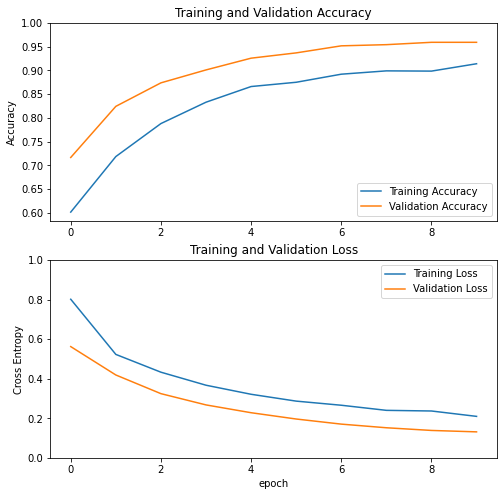

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:07 - loss: 0.1438 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.1764 - accuracy: 0.9141  

 7/63 [==>...........................] - ETA: 1s - loss: 0.1496 - accuracy: 0.9330

10/63 [===>..........................] - ETA: 1s - loss: 0.1577 - accuracy: 0.9312

13/63 [=====>........................] - ETA: 1s - loss: 0.1564 - accuracy: 0.9375

16/63 [======>.......................] - ETA: 0s - loss: 0.1499 - accuracy: 0.9414

19/63 [========>.....................] - ETA: 0s - loss: 0.1665 - accuracy: 0.9293

22/63 [=========>....................] - ETA: 0s - loss: 0.1647 - accuracy: 0.9276

25/63 [==========>...................] - ETA: 0s - loss: 0.1584 - accuracy: 0.9312

28/63 [============>.................] - ETA: 0s - loss: 0.1590 - accuracy: 0.9308

31/63 [=============>................] - ETA: 0s - loss: 0.1646 - accuracy: 0.9274

34/63 [===============>..............] - ETA: 0s - loss: 0.1592 - accuracy: 0.9292

37/63 [================>.............] - ETA: 0s - loss: 0.1619 - accuracy: 0.9274

40/63 [==================>...........] - ETA: 0s - loss: 0.1609 - accuracy: 0.9289

43/63 [===================>..........] - ETA: 0s - loss: 0.1631 - accuracy: 0.9295

46/63 [====================>.........] - ETA: 0s - loss: 0.1630 - accuracy: 0.9307

49/63 [======================>.......] - ETA: 0s - loss: 0.1565 - accuracy: 0.9337

52/63 [=======================>......] - ETA: 0s - loss: 0.1535 - accuracy: 0.9333

55/63 [=========================>....] - ETA: 0s - loss: 0.1507 - accuracy: 0.9352

58/63 [==========================>...] - ETA: 0s - loss: 0.1511 - accuracy: 0.9353

61/63 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9360

63/63 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9375

63/63 [==============================] - 6s 38ms/step - loss: 0.1514 - accuracy: 0.9375 - val_loss: 0.0548 - val_accuracy: 0.9740


Epoch 11/20
 1/63 [..............................] - ETA: 5s - loss: 0.0626 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.1141 - accuracy: 0.9609

 7/63 [==>...........................] - ETA: 1s - loss: 0.1448 - accuracy: 0.9464

10/63 [===>..........................] - ETA: 1s - loss: 0.1178 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 1s - loss: 0.1031 - accuracy: 0.9591

16/63 [======>.......................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9570

19/63 [========>.....................] - ETA: 0s - loss: 0.1068 - accuracy: 0.9556

22/63 [=========>....................] - ETA: 0s - loss: 0.1083 - accuracy: 0.9574

25/63 [==========>...................] - ETA: 0s - loss: 0.1033 - accuracy: 0.9600

28/63 [============>.................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9609

31/63 [=============>................] - ETA: 0s - loss: 0.1069 - accuracy: 0.9597

34/63 [===============>..............] - ETA: 0s - loss: 0.1086 - accuracy: 0.9586

37/63 [================>.............] - ETA: 0s - loss: 0.1055 - accuracy: 0.9595

40/63 [==================>...........] - ETA: 0s - loss: 0.1073 - accuracy: 0.9570

43/63 [===================>..........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9571

46/63 [====================>.........] - ETA: 0s - loss: 0.1051 - accuracy: 0.9558

49/63 [======================>.......] - ETA: 0s - loss: 0.1154 - accuracy: 0.9528

52/63 [=======================>......] - ETA: 0s - loss: 0.1166 - accuracy: 0.9519

55/63 [=========================>....] - ETA: 0s - loss: 0.1184 - accuracy: 0.9500

58/63 [==========================>...] - ETA: 0s - loss: 0.1187 - accuracy: 0.9510

61/63 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.9493

63/63 [==============================] - 2s 27ms/step - loss: 0.1262 - accuracy: 0.9490 - val_loss: 0.0597 - val_accuracy: 0.9691


Epoch 12/20
 1/63 [..............................] - ETA: 5s - loss: 0.1595 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.1160 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.1051 - accuracy: 0.9464

10/63 [===>..........................] - ETA: 1s - loss: 0.1290 - accuracy: 0.9438

13/63 [=====>........................] - ETA: 1s - loss: 0.1196 - accuracy: 0.9447

16/63 [======>.......................] - ETA: 0s - loss: 0.1276 - accuracy: 0.9434

19/63 [========>.....................] - ETA: 0s - loss: 0.1206 - accuracy: 0.9507

22/63 [=========>....................] - ETA: 0s - loss: 0.1154 - accuracy: 0.9531

25/63 [==========>...................] - ETA: 0s - loss: 0.1144 - accuracy: 0.9525

28/63 [============>.................] - ETA: 0s - loss: 0.1138 - accuracy: 0.9531

31/63 [=============>................] - ETA: 0s - loss: 0.1091 - accuracy: 0.9536

34/63 [===============>..............] - ETA: 0s - loss: 0.1045 - accuracy: 0.9559

37/63 [================>.............] - ETA: 0s - loss: 0.1043 - accuracy: 0.9578

40/63 [==================>...........] - ETA: 0s - loss: 0.1040 - accuracy: 0.9578

43/63 [===================>..........] - ETA: 0s - loss: 0.1025 - accuracy: 0.9586

46/63 [====================>.........] - ETA: 0s - loss: 0.0989 - accuracy: 0.9606

49/63 [======================>.......] - ETA: 0s - loss: 0.1124 - accuracy: 0.9566

52/63 [=======================>......] - ETA: 0s - loss: 0.1096 - accuracy: 0.9579

55/63 [=========================>....] - ETA: 0s - loss: 0.1083 - accuracy: 0.9585

58/63 [==========================>...] - ETA: 0s - loss: 0.1060 - accuracy: 0.9596

61/63 [============================>.] - ETA: 0s - loss: 0.1074 - accuracy: 0.9595

63/63 [==============================] - 2s 26ms/step - loss: 0.1073 - accuracy: 0.9595 - val_loss: 0.0444 - val_accuracy: 0.9777


Epoch 13/20
 1/63 [..............................] - ETA: 5s - loss: 0.1793 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.1193 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.1057 - accuracy: 0.9554

10/63 [===>..........................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9563

13/63 [=====>........................] - ETA: 1s - loss: 0.0828 - accuracy: 0.9639

16/63 [======>.......................] - ETA: 0s - loss: 0.0791 - accuracy: 0.9648

19/63 [========>.....................] - ETA: 0s - loss: 0.0826 - accuracy: 0.9638

22/63 [=========>....................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9588

25/63 [==========>...................] - ETA: 0s - loss: 0.0797 - accuracy: 0.9625

28/63 [============>.................] - ETA: 0s - loss: 0.0831 - accuracy: 0.9609

31/63 [=============>................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9587

34/63 [===============>..............] - ETA: 0s - loss: 0.0951 - accuracy: 0.9559

37/63 [================>.............] - ETA: 0s - loss: 0.0969 - accuracy: 0.9552

40/63 [==================>...........] - ETA: 0s - loss: 0.0942 - accuracy: 0.9570

43/63 [===================>..........] - ETA: 0s - loss: 0.0938 - accuracy: 0.9571

46/63 [====================>.........] - ETA: 0s - loss: 0.0938 - accuracy: 0.9572

49/63 [======================>.......] - ETA: 0s - loss: 0.0944 - accuracy: 0.9585

52/63 [=======================>......] - ETA: 0s - loss: 0.0942 - accuracy: 0.9597

55/63 [=========================>....] - ETA: 0s - loss: 0.0943 - accuracy: 0.9602

58/63 [==========================>...] - ETA: 0s - loss: 0.0989 - accuracy: 0.9591

61/63 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9585

63/63 [==============================] - 2s 27ms/step - loss: 0.0997 - accuracy: 0.9590 - val_loss: 0.0437 - val_accuracy: 0.9777


Epoch 14/20
 1/63 [..............................] - ETA: 5s - loss: 0.0369 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0667 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0586 - accuracy: 0.9777

10/63 [===>..........................] - ETA: 1s - loss: 0.0743 - accuracy: 0.9656

13/63 [=====>........................] - ETA: 1s - loss: 0.0710 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 0s - loss: 0.0837 - accuracy: 0.9668

19/63 [========>.....................] - ETA: 0s - loss: 0.0858 - accuracy: 0.9671

22/63 [=========>....................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9673

25/63 [==========>...................] - ETA: 0s - loss: 0.0901 - accuracy: 0.9650

28/63 [============>.................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9654

31/63 [=============>................] - ETA: 0s - loss: 0.0853 - accuracy: 0.9657

34/63 [===============>..............] - ETA: 0s - loss: 0.0909 - accuracy: 0.9614

37/63 [================>.............] - ETA: 0s - loss: 0.0914 - accuracy: 0.9620

40/63 [==================>...........] - ETA: 0s - loss: 0.0917 - accuracy: 0.9625

43/63 [===================>..........] - ETA: 0s - loss: 0.0933 - accuracy: 0.9622

46/63 [====================>.........] - ETA: 0s - loss: 0.0909 - accuracy: 0.9640

49/63 [======================>.......] - ETA: 0s - loss: 0.0923 - accuracy: 0.9649

52/63 [=======================>......] - ETA: 0s - loss: 0.0933 - accuracy: 0.9645

55/63 [=========================>....] - ETA: 0s - loss: 0.0958 - accuracy: 0.9636

58/63 [==========================>...] - ETA: 0s - loss: 0.0959 - accuracy: 0.9623

61/63 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9616

63/63 [==============================] - 2s 26ms/step - loss: 0.0983 - accuracy: 0.9610 - val_loss: 0.0466 - val_accuracy: 0.9790


Epoch 15/20
 1/63 [..............................] - ETA: 5s - loss: 0.0285 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0627 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0585 - accuracy: 0.9732

10/63 [===>..........................] - ETA: 1s - loss: 0.0663 - accuracy: 0.9750

13/63 [=====>........................] - ETA: 0s - loss: 0.0783 - accuracy: 0.9736

16/63 [======>.......................] - ETA: 0s - loss: 0.0683 - accuracy: 0.9785

19/63 [========>.....................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9786

22/63 [=========>....................] - ETA: 0s - loss: 0.0753 - accuracy: 0.9730

25/63 [==========>...................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9725

28/63 [============>.................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9743

31/63 [=============>................] - ETA: 0s - loss: 0.0766 - accuracy: 0.9738

34/63 [===============>..............] - ETA: 0s - loss: 0.0775 - accuracy: 0.9724

37/63 [================>.............] - ETA: 0s - loss: 0.0763 - accuracy: 0.9721

40/63 [==================>...........] - ETA: 0s - loss: 0.0735 - accuracy: 0.9727

43/63 [===================>..........] - ETA: 0s - loss: 0.0724 - accuracy: 0.9738

46/63 [====================>.........] - ETA: 0s - loss: 0.0763 - accuracy: 0.9715

49/63 [======================>.......] - ETA: 0s - loss: 0.0766 - accuracy: 0.9713

52/63 [=======================>......] - ETA: 0s - loss: 0.0751 - accuracy: 0.9718

55/63 [=========================>....] - ETA: 0s - loss: 0.0746 - accuracy: 0.9727

58/63 [==========================>...] - ETA: 0s - loss: 0.0730 - accuracy: 0.9736

61/63 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9739

63/63 [==============================] - 2s 27ms/step - loss: 0.0715 - accuracy: 0.9740 - val_loss: 0.0378 - val_accuracy: 0.9814


Epoch 16/20
 1/63 [..............................] - ETA: 5s - loss: 0.0163 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0793 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9625

13/63 [=====>........................] - ETA: 1s - loss: 0.0701 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 0s - loss: 0.0593 - accuracy: 0.9727

19/63 [========>.....................] - ETA: 0s - loss: 0.0668 - accuracy: 0.9704

22/63 [=========>....................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9716

25/63 [==========>...................] - ETA: 0s - loss: 0.0621 - accuracy: 0.9725

28/63 [============>.................] - ETA: 0s - loss: 0.0583 - accuracy: 0.9754

31/63 [=============>................] - ETA: 0s - loss: 0.0607 - accuracy: 0.9728

34/63 [===============>..............] - ETA: 0s - loss: 0.0600 - accuracy: 0.9733

37/63 [================>.............] - ETA: 0s - loss: 0.0607 - accuracy: 0.9738

40/63 [==================>...........] - ETA: 0s - loss: 0.0662 - accuracy: 0.9734

43/63 [===================>..........] - ETA: 0s - loss: 0.0679 - accuracy: 0.9731

46/63 [====================>.........] - ETA: 0s - loss: 0.0744 - accuracy: 0.9728

49/63 [======================>.......] - ETA: 0s - loss: 0.0781 - accuracy: 0.9713

52/63 [=======================>......] - ETA: 0s - loss: 0.0791 - accuracy: 0.9706

55/63 [=========================>....] - ETA: 0s - loss: 0.0769 - accuracy: 0.9716

58/63 [==========================>...] - ETA: 0s - loss: 0.0758 - accuracy: 0.9714

61/63 [============================>.] - ETA: 0s - loss: 0.0750 - accuracy: 0.9723

63/63 [==============================] - 2s 26ms/step - loss: 0.0753 - accuracy: 0.9720 - val_loss: 0.0465 - val_accuracy: 0.9765


Epoch 17/20
 1/63 [..............................] - ETA: 5s - loss: 0.1599 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.0822 - accuracy: 0.9453

 7/63 [==>...........................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9598

10/63 [===>..........................] - ETA: 1s - loss: 0.0834 - accuracy: 0.9625

13/63 [=====>........................] - ETA: 1s - loss: 0.0856 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 0s - loss: 0.0773 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 0s - loss: 0.0834 - accuracy: 0.9638

22/63 [=========>....................] - ETA: 0s - loss: 0.0882 - accuracy: 0.9631

25/63 [==========>...................] - ETA: 0s - loss: 0.0904 - accuracy: 0.9638

28/63 [============>.................] - ETA: 0s - loss: 0.0893 - accuracy: 0.9643

31/63 [=============>................] - ETA: 0s - loss: 0.0850 - accuracy: 0.9667

34/63 [===============>..............] - ETA: 0s - loss: 0.0819 - accuracy: 0.9678

37/63 [================>.............] - ETA: 0s - loss: 0.0777 - accuracy: 0.9696

40/63 [==================>...........] - ETA: 0s - loss: 0.0750 - accuracy: 0.9711

43/63 [===================>..........] - ETA: 0s - loss: 0.0727 - accuracy: 0.9724

46/63 [====================>.........] - ETA: 0s - loss: 0.0750 - accuracy: 0.9721

49/63 [======================>.......] - ETA: 0s - loss: 0.0734 - accuracy: 0.9719

52/63 [=======================>......] - ETA: 0s - loss: 0.0706 - accuracy: 0.9730

55/63 [=========================>....] - ETA: 0s - loss: 0.0701 - accuracy: 0.9722

58/63 [==========================>...] - ETA: 0s - loss: 0.0740 - accuracy: 0.9704

61/63 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9703

63/63 [==============================] - 2s 27ms/step - loss: 0.0727 - accuracy: 0.9710 - val_loss: 0.0348 - val_accuracy: 0.9827


Epoch 18/20
 1/63 [..............................] - ETA: 5s - loss: 0.0145 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.0602 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 1s - loss: 0.0760 - accuracy: 0.9625

13/63 [=====>........................] - ETA: 0s - loss: 0.0701 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 0s - loss: 0.0634 - accuracy: 0.9707

19/63 [========>.....................] - ETA: 0s - loss: 0.0620 - accuracy: 0.9720

22/63 [=========>....................] - ETA: 0s - loss: 0.0630 - accuracy: 0.9702

25/63 [==========>...................] - ETA: 0s - loss: 0.0631 - accuracy: 0.9725

28/63 [============>.................] - ETA: 0s - loss: 0.0624 - accuracy: 0.9721

31/63 [=============>................] - ETA: 0s - loss: 0.0599 - accuracy: 0.9738

34/63 [===============>..............] - ETA: 0s - loss: 0.0573 - accuracy: 0.9752

37/63 [================>.............] - ETA: 0s - loss: 0.0618 - accuracy: 0.9713

40/63 [==================>...........] - ETA: 0s - loss: 0.0605 - accuracy: 0.9719

43/63 [===================>..........] - ETA: 0s - loss: 0.0615 - accuracy: 0.9702

46/63 [====================>.........] - ETA: 0s - loss: 0.0611 - accuracy: 0.9715

49/63 [======================>.......] - ETA: 0s - loss: 0.0599 - accuracy: 0.9726

52/63 [=======================>......] - ETA: 0s - loss: 0.0600 - accuracy: 0.9730

55/63 [=========================>....] - ETA: 0s - loss: 0.0663 - accuracy: 0.9693

58/63 [==========================>...] - ETA: 0s - loss: 0.0671 - accuracy: 0.9698

61/63 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9708

63/63 [==============================] - 2s 26ms/step - loss: 0.0638 - accuracy: 0.9715 - val_loss: 0.0393 - val_accuracy: 0.9839


Epoch 19/20
 1/63 [..............................] - ETA: 5s - loss: 0.0158 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0185 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 1s - loss: 0.0299 - accuracy: 0.9911

10/63 [===>..........................] - ETA: 1s - loss: 0.0348 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 1s - loss: 0.0337 - accuracy: 0.9832

16/63 [======>.......................] - ETA: 0s - loss: 0.0327 - accuracy: 0.9844

19/63 [========>.....................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9819

22/63 [=========>....................] - ETA: 0s - loss: 0.0383 - accuracy: 0.9787

25/63 [==========>...................] - ETA: 0s - loss: 0.0401 - accuracy: 0.9800

28/63 [============>.................] - ETA: 0s - loss: 0.0420 - accuracy: 0.9788

31/63 [=============>................] - ETA: 0s - loss: 0.0427 - accuracy: 0.9798

34/63 [===============>..............] - ETA: 0s - loss: 0.0449 - accuracy: 0.9779

37/63 [================>.............] - ETA: 0s - loss: 0.0509 - accuracy: 0.9772

40/63 [==================>...........] - ETA: 0s - loss: 0.0509 - accuracy: 0.9773

43/63 [===================>..........] - ETA: 0s - loss: 0.0509 - accuracy: 0.9767

46/63 [====================>.........] - ETA: 0s - loss: 0.0596 - accuracy: 0.9735

49/63 [======================>.......] - ETA: 0s - loss: 0.0589 - accuracy: 0.9745

52/63 [=======================>......] - ETA: 0s - loss: 0.0574 - accuracy: 0.9748

55/63 [=========================>....] - ETA: 0s - loss: 0.0562 - accuracy: 0.9750

58/63 [==========================>...] - ETA: 0s - loss: 0.0575 - accuracy: 0.9741

61/63 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9749

63/63 [==============================] - 2s 27ms/step - loss: 0.0552 - accuracy: 0.9755 - val_loss: 0.0349 - val_accuracy: 0.9851


Epoch 20/20
 1/63 [..............................] - ETA: 5s - loss: 0.1079 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0500 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0634 - accuracy: 0.9777

10/63 [===>..........................] - ETA: 1s - loss: 0.0510 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 1s - loss: 0.0492 - accuracy: 0.9856

16/63 [======>.......................] - ETA: 0s - loss: 0.0560 - accuracy: 0.9805

19/63 [========>.....................] - ETA: 0s - loss: 0.0618 - accuracy: 0.9753

22/63 [=========>....................] - ETA: 0s - loss: 0.0640 - accuracy: 0.9716

25/63 [==========>...................] - ETA: 0s - loss: 0.0652 - accuracy: 0.9725

28/63 [============>.................] - ETA: 0s - loss: 0.0654 - accuracy: 0.9732

31/63 [=============>................] - ETA: 0s - loss: 0.0663 - accuracy: 0.9738

34/63 [===============>..............] - ETA: 0s - loss: 0.0648 - accuracy: 0.9743

37/63 [================>.............] - ETA: 0s - loss: 0.0643 - accuracy: 0.9747

40/63 [==================>...........] - ETA: 0s - loss: 0.0651 - accuracy: 0.9734

43/63 [===================>..........] - ETA: 0s - loss: 0.0664 - accuracy: 0.9731

46/63 [====================>.........] - ETA: 0s - loss: 0.0661 - accuracy: 0.9721

49/63 [======================>.......] - ETA: 0s - loss: 0.0652 - accuracy: 0.9719

52/63 [=======================>......] - ETA: 0s - loss: 0.0652 - accuracy: 0.9706

55/63 [=========================>....] - ETA: 0s - loss: 0.0625 - accuracy: 0.9722

58/63 [==========================>...] - ETA: 0s - loss: 0.0600 - accuracy: 0.9736

61/63 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9744

63/63 [==============================] - 2s 27ms/step - loss: 0.0605 - accuracy: 0.9730 - val_loss: 0.0419 - val_accuracy: 0.9864


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

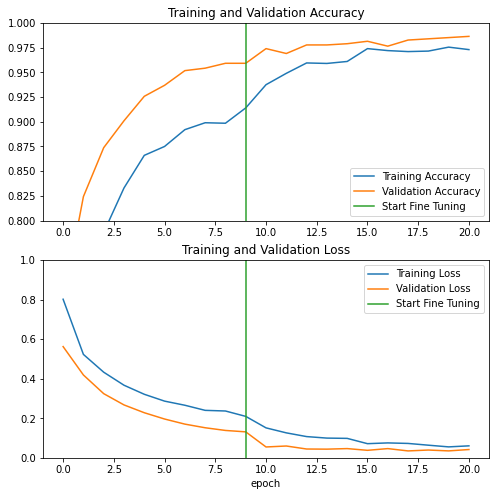

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.1018 - accuracy: 0.9688

6/6 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9792

6/6 [==============================] - 0s 13ms/step - loss: 0.0438 - accuracy: 0.9792


Test accuracy : 0.9791666865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1]
Labels:
 [0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1]


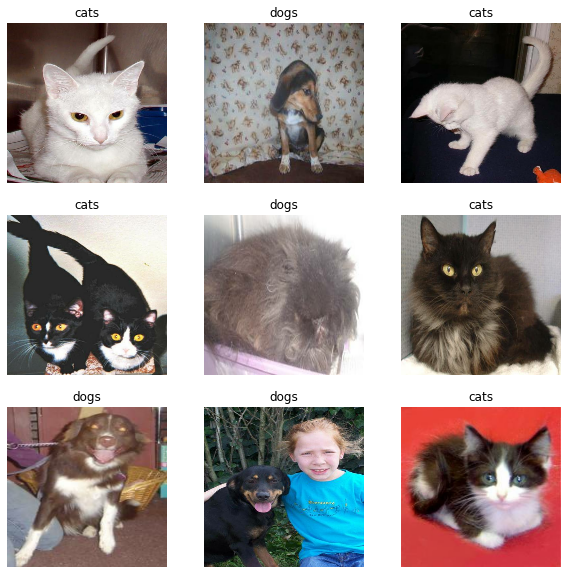

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
